In [49]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  7 09:59:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   8765MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [50]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.8 s (started: 2022-02-07 09:59:27 +00:00)


In [51]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 2.11 ms (started: 2022-02-07 09:59:31 +00:00)


In [52]:
!pip install --quiet optuna

time: 2.91 s (started: 2022-02-07 09:59:31 +00:00)


In [53]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 16.4 ms (started: 2022-02-07 09:59:34 +00:00)


# Variables

## Paths

In [54]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220207_09H59/
time: 7.33 ms (started: 2022-02-07 09:59:34 +00:00)


## Other

In [55]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 25
# learing rate 
# learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 16 #32
# base model trainable 
# base_model_trainable = True


#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 17.7 ms (started: 2022-02-07 09:59:34 +00:00)


# Load & filter data

## Unzip images

In [56]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 9.17 ms (started: 2022-02-07 09:59:34 +00:00)


In [57]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 4.36 ms (started: 2022-02-07 09:59:34 +00:00)


## File_path df

In [58]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.99 s (started: 2022-02-07 09:59:34 +00:00)


In [59]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 3.74 ms (started: 2022-02-07 09:59:36 +00:00)


In [60]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 275 ms (started: 2022-02-07 09:59:36 +00:00)


In [61]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 153 ms (started: 2022-02-07 09:59:36 +00:00)


In [62]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 48.4 ms (started: 2022-02-07 09:59:36 +00:00)


In [63]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 41.9 ms (started: 2022-02-07 09:59:37 +00:00)


In [64]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 75.9 ms (started: 2022-02-07 09:59:37 +00:00)


In [65]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 20 ms (started: 2022-02-07 09:59:37 +00:00)


In [66]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 24 ms (started: 2022-02-07 09:59:37 +00:00)


In [67]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.1 ms (started: 2022-02-07 09:59:37 +00:00)


In [68]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 2.51 ms (started: 2022-02-07 09:59:37 +00:00)


In [69]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 11.1 ms (started: 2022-02-07 09:59:37 +00:00)


In [70]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 55.7 ms (started: 2022-02-07 09:59:37 +00:00)


In [71]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 2.24 ms (started: 2022-02-07 09:59:37 +00:00)


In [72]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 38.9 ms (started: 2022-02-07 09:59:37 +00:00)


In [73]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 7.41 ms (started: 2022-02-07 09:59:37 +00:00)


## Train/test split

In [74]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22903, 3) (5726, 3) (7158, 3)
time: 72.8 ms (started: 2022-02-07 09:59:37 +00:00)


In [75]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 28.7 ms (started: 2022-02-07 09:59:37 +00:00)


### Plot few images

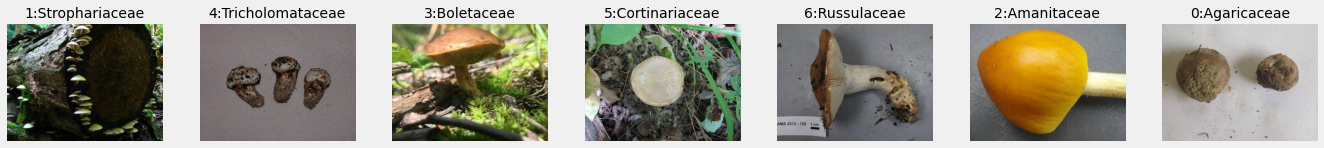

time: 458 ms (started: 2022-02-07 09:59:37 +00:00)


In [76]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

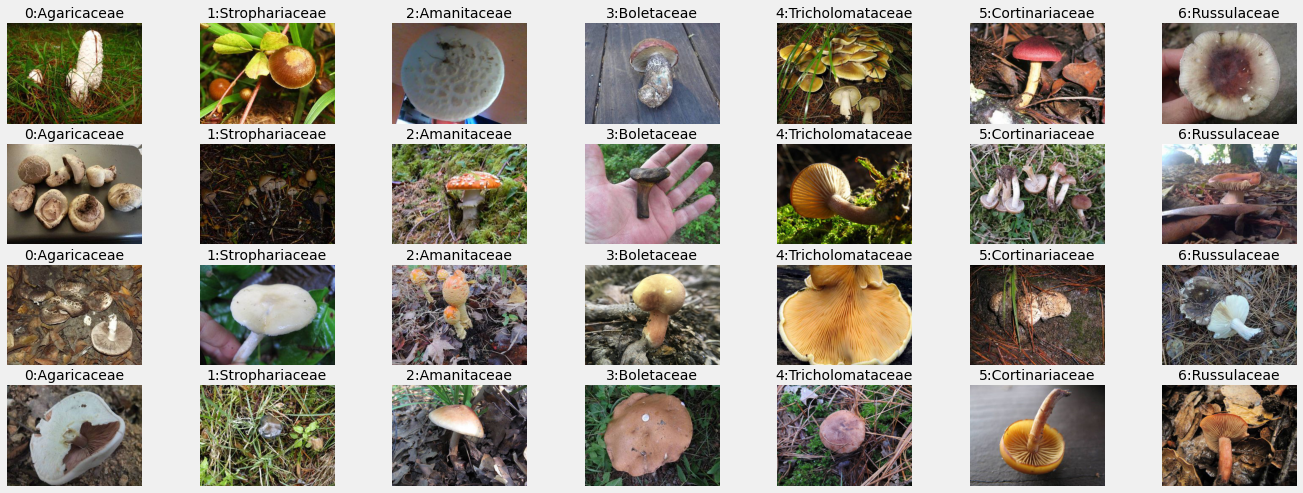

time: 1.65 s (started: 2022-02-07 09:59:37 +00:00)


In [77]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Callbacks & Fonctions

In [96]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=2, # Attendre 2 epochs avant application
                                min_delta = 0.02, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 7.24 ms (started: 2022-02-07 10:23:27 +00:00)


In [79]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 15.8 ms (started: 2022-02-07 09:59:39 +00:00)


In [80]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.axvline(x=max_epoch_freeze-1, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.axvline(x=max_epoch_freeze-1, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 30.7 ms (started: 2022-02-07 09:59:39 +00:00)


In [81]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 36.1 ms (started: 2022-02-07 09:59:39 +00:00)


In [82]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 49.1 ms (started: 2022-02-07 09:59:39 +00:00)


# Top3 model fit

## Dict of model param found in previous notebook

In [83]:
optuna_trials_dir = DL_dir + 'Optuna for DL classifier optimization/'+ '220207_06H35/' 
optuna_trials_path = optuna_trials_dir + 'optuna_trials.csv'

time: 1.15 ms (started: 2022-02-07 09:59:39 +00:00)


In [84]:
# get best param from optuna study 
optuna_trials_df = pd.read_csv(optuna_trials_path, index_col= 'number' )
optuna_trials_df = optuna_trials_df.sort_values(by=['value'],ascending = False)
optuna_trials_df

,Unnamed: 0,value,datetime_start,datetime_complete,duration,params_dropout_rate_0,params_dropout_rate_1,params_lr,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,state
number,,,,,,,,,,,,
9,9,0.66625,2022-02-07 07:58:28.061114,2022-02-07 08:14:21.869130,0 days 00:15:53.808016,0.3,0.2,0.000100,0.56000,0.56500,0.64250,COMPLETE
2,2,0.64625,2022-02-07 07:04:47.170416,2022-02-07 07:21:06.155633,0 days 00:16:18.985217,0.3,0.1,0.000059,0.53750,0.56000,0.62625,COMPLETE
4,4,0.63375,2022-02-07 07:23:14.001345,2022-02-07 07:39:37.444617,0 days 00:16:23.443272,0.7,0.6,0.000108,0.55250,0.63000,NaN,COMPLETE
1,1,0.62875,2022-02-07 06:47:04.672480,2022-02-07 07:04:47.168240,0 days 00:17:42.495760,0.8,0.0,0.000390,0.52750,0.55875,0.57250,COMPLETE
16,16,0.60625,2022-02-07 08:37:11.711974,2022-02-07 08:48:48.344693,0 days 00:11:36.632719,0.1,0.7,0.000203,0.55375,0.56875,0.60625,PRUNED
18,18,0.59375,2022-02-07 08:50:59.300522,2022-02-07 09:01:47.226887,0 days 00:10:47.926365,0.4,0.1,0.000317,0.57875,0.59375,NaN,PRUNED
24,24,0.59250,2022-02-07 09:23:35.471123,2022-02-07 09:35:00.755953,0 days 00:11:25.284830,0.0,0.3,0.000087,0.56500,0.59250,NaN,PRUNED
20,20,0.58500,2022-02-07 09:05:51.634435,2022-02-07 09:16:41.183078,0 days 00:10:49.548643,0.6,0.7,0.000302,0.56125,0.58500,NaN,PRUNED
14,14,0.56250,2022-02-07 08:29:04.262690,2022-02-07 08:33:08.444204,0 days 00:04:04.181514,0.2,0.5,0.000534,0.55375,0.56250,NaN,PRUNED


time: 703 ms (started: 2022-02-07 09:59:39 +00:00)


In [86]:
# extract top3 param 
top3_trials_df = optuna_trials_df.head(3)
# extract param only : 1 dict for each trials 
top_3_params = []
for i in range(len(top3_trials_df)):
  param_dict = {} 
  trial_dict = top3_trials_df.iloc[i].to_dict()
  for k,v in trial_dict.items():
    if 'params_' in k and np.isnan(v)==False:
      param_dict[k.replace('params_','')] = v
  top_3_params.append(param_dict) 

top_3_params

[{'dropout_rate_0': 0.3, 'dropout_rate_1': 0.2, 'lr': 9.972011089930672e-05},
 {'dropout_rate_0': 0.3, 'dropout_rate_1': 0.1, 'lr': 5.857742214054853e-05},
 {'dropout_rate_0': 0.7000000000000001,
  'dropout_rate_1': 0.6000000000000001,
  'lr': 0.0001078244778114}]

time: 11 ms (started: 2022-02-07 10:06:09 +00:00)


## Fit loop on top 3 models

In [87]:
# define base model  
model_name = 'EFB1'
base_model = tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False)
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
print(export_dir,'\n',pathinfos)

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220207_09H59/ 
 EFB1_(240, 320)_7families_28629_images
time: 2.59 s (started: 2022-02-07 10:06:10 +00:00)


In [88]:
# # ONE STEP 
# model_metric = {}
# model_number = 0
# for param_dict in top_3_params:
#   print('*'*150)
#   model_number_str =  '_model_#' + str(model_number) # for save figs paths 
#   # Clear clutter from previous TensorFlow graphs.
#   tf.keras.backend.clear_session()
#   # define set of model params 
#   batch_size  = param_dict['batch_size']
#   lr = param_dict['lr']
#   num_layer = len([param_name for param_name in param_dict.keys() if 'num_units_' in param_name ])
#   layer_units, layer_dropouts = {}, {}
#   for k,v in param_dict.items():
#     if 'num_units' in k:
#       layer_units[int(k[-1:])] = v
#     if 'dropout_rate' in k:
#       layer_dropouts[int(k[-1:])] = v
#   # datagen 
#   # train 
#   train_data_generator = ImageDataGenerator() 
#   train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
#                                                             x_col = "drive_file_path",y_col="label", 
#                                                             target_size=resol,batch_size=batch_size,class_mode='sparse')
#   # val
#   val_data_generator = ImageDataGenerator() 
#   val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
#                                                             x_col = "drive_file_path",y_col="label", 
#                                                             target_size=resol,batch_size=batch_size,class_mode='sparse')

#   #test 
#   test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
#                                                           x_col = "drive_file_path",y_col="label", 
#                                                           shuffle = False, # to match df_test order 
#                                                             target_size=resol,batch_size=batch_size,class_mode='sparse')

#   # construct model 
#   # base + average 
#   layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
#   # dense + dropout 
#   for i in range(num_layer):
#         layers.append(tf.keras.layers.Dense(units =layer_units[i], activation = 'relu'))
#         layers.append(tf.keras.layers.Dropout(layer_dropouts[i]))
#   # prediction 
#   layers.append(Dense(units = classes_count, activation = 'softmax'))
#   #freeze/unfreeze all layers 
#   for layer in base_model.layers:
#       layer.trainable = True
#   # print param 
#   text = str(param_dict)
#   t1, t2 = text[:len(text)//2],text[len(text)//2:]
#   print('model {} start'.format(i))
#   print(t1 + '\n' + t2)
#   #create model 
#   model = tf.keras.Sequential(layers,name = model_name)
#   model.summary()
#   # export summary model & param 
#   with open(export_dir + pathinfos  + '_model_#' + str(i) + '_modelsummary.txt', 'w') as f:
#       model.summary(print_fn=lambda x: f.write(x + '\n'))
#   pd.DataFrame.from_dict(param_dict, orient = 'index').to_csv(export_dir + pathinfos  + 'model_' + str(i) +  '_modelparam.csv')
#   # compilation 
#   optimizer =  'Adam'
#   model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
#   K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
#   # Entraînement
#   tic = time.time() # timer start
#   training_history_model = model.fit(train_generator,epochs=epochs,
#                                   steps_per_epoch = len(df_train_)//batch_size,
#                                   validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
#                                    class_weight=class_weights,
#                                   callbacks=[
#                                              early_stopping,reduce_learning_rate, #KERAS
#                                              ],
#                                   # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
#                                   ) 
#   training_history_model = training_history_model.history
#   # timer end 
#   tac = time.time()
#   time_to_fit = tic - tac
#   print('fite time = {}'.format(-round(time_to_fit/60,1)))
#   # Plot hIStory 
#   training_history_fig = plot_history(training_history_model,pathinfos)
#   #  add model infos
#   training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
#   display(training_history_fig)
#   # save fig + model summary
#   training_history_fig.savefig(export_dir + pathinfos +  model_number_str  +  '_training_history.jpeg',bbox_inches = 'tight' )
#   with open(export_dir + pathinfos +  model_number_str  +  '_modelsummary.txt', 'w') as f:
#     model.summary(print_fn=lambda x: f.write(x + '\n'))
#   # on regarde ce que ça donne sur test set (normalement doit pas le faire)
#   print("*"*50 + 'TEST set classification report' + '*'*50)
#   # predict 
#   y_prob = model.predict(test_generator,len(df_test)//batch_size)
#   test_pred_class= np.argmax(y_prob , axis=1)
#   # true label
#   y_test_class= df_test['label'].values.astype(int)
#   # report 
#   # print(metrics.classification_report(y_test_class, test_pred_class))
#   # save report
#   report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
#   report = pd.DataFrame(report).transpose()
#   report_path = export_dir + pathinfos +  model_number_str + '_classification report.csv'
#   report.to_csv(report_path)
#   # conf matrix 
#   classes = df['gbif_info.family'].nunique()  # classes
#   # label and count for legend 
#   unique, counts = np.unique(y_test_class, return_counts=True)
#   test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
#   test_dict_label = dict_label_df.merge(test_dict_label,on='label')
#   test_dict_label = test_dict_label.drop(['size'], axis=1)
#   # plot 
#   conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
#   display(conf_matrix_fig)
#   # save fig 
#   conf_matrix_fig.savefig(export_dir + pathinfos +  model_number_str +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
#   # add metric 
#   model_metric['model_#' + str(model_number)] = [training_history_model['accuracy'][-1],
#                                                  training_history_model['val_accuracy'][-1],
#                                                  accuracy_score(y_test_class , test_pred_class),
#                                                   f1_score(y_test_class , test_pred_class,average='weighted'),
#                                                  time_to_fit ]
#   model_number = model_number +1

time: 11.4 ms (started: 2022-02-07 10:06:12 +00:00)


******************************************************************************************************************************************************
Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
model 2 start
{'dropout_rate_0': 0.3, 'dropout_rate
_1': 0.2, 'lr': 9.972011089930672e-05}
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                

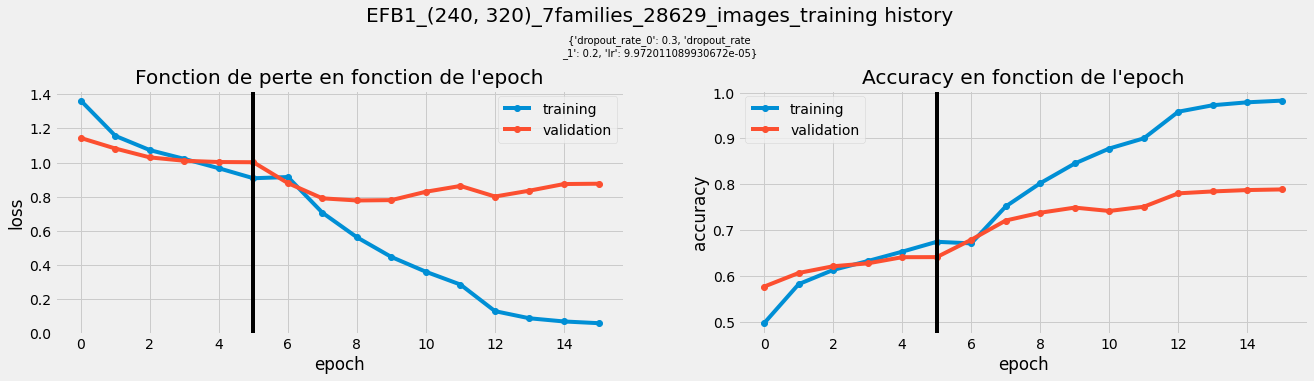

**************************************************TEST set classification report**************************************************


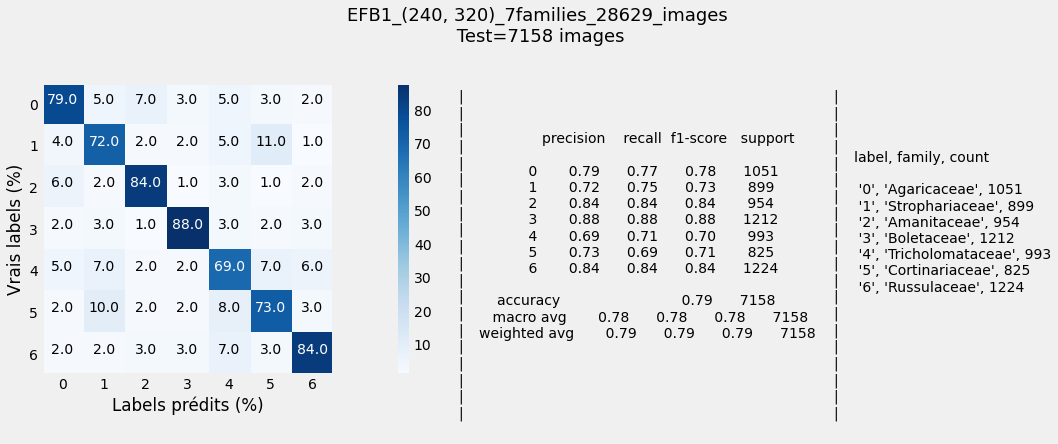

******************************************************************************************************************************************************
Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
model 2 start
{'dropout_rate_0': 0.3, 'dropout_rate
_1': 0.1, 'lr': 5.857742214054853e-05}
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                

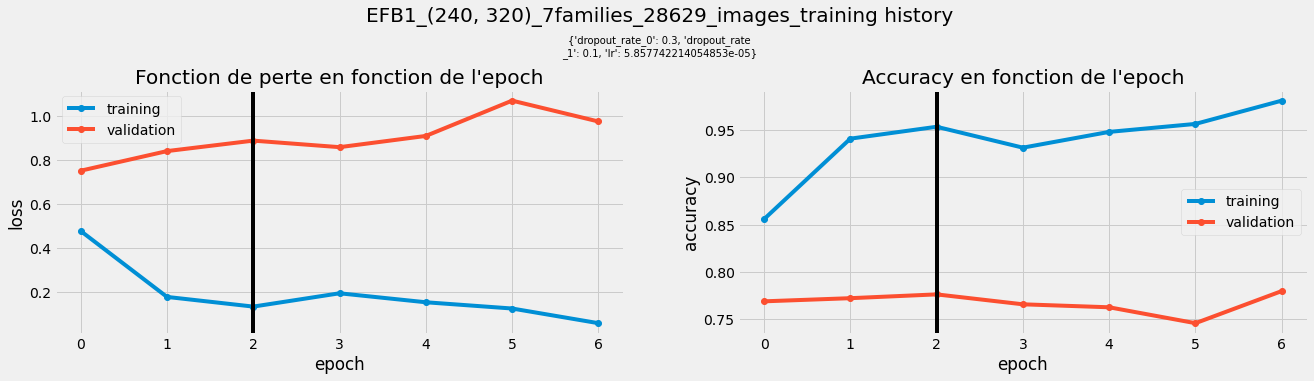

**************************************************TEST set classification report**************************************************


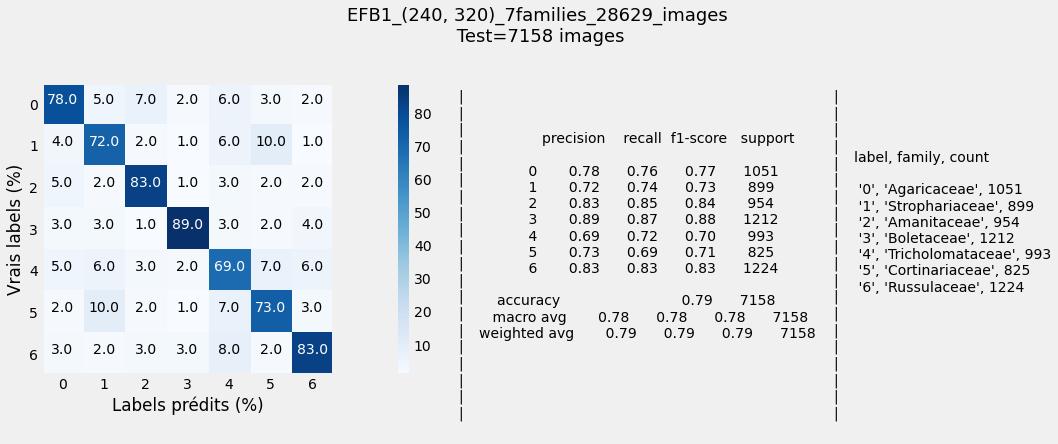

******************************************************************************************************************************************************
Found 22903 validated image filenames belonging to 7 classes.
Found 5726 validated image filenames belonging to 7 classes.
Found 7158 validated image filenames belonging to 7 classes.
model 2 start
{'dropout_rate_0': 0.7000000000000001, 'dropout_rat
e_1': 0.6000000000000001, 'lr': 0.0001078244778114}
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
     

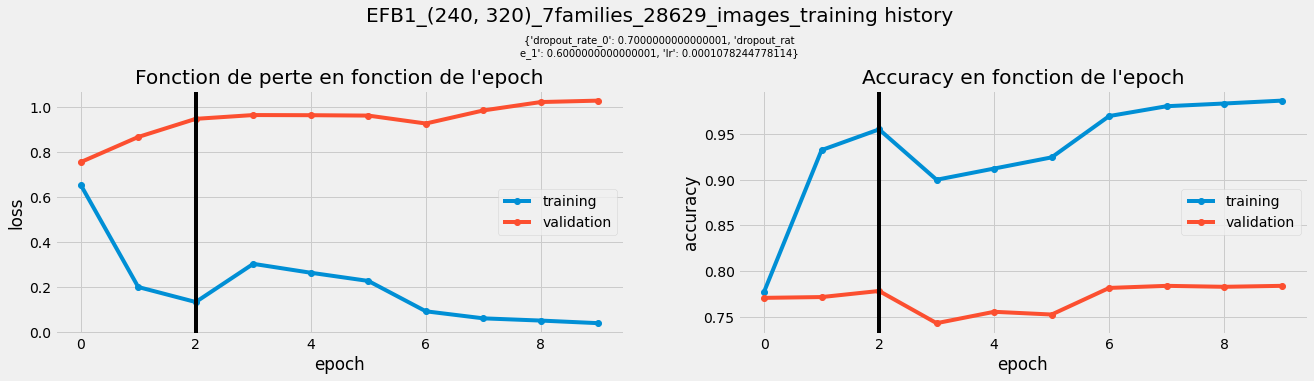

**************************************************TEST set classification report**************************************************


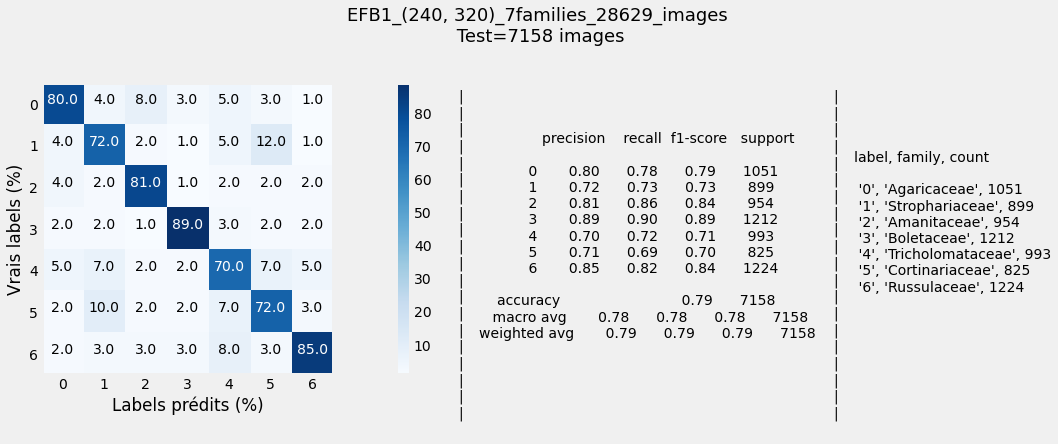

time: 4h 36min 56s (started: 2022-02-07 10:23:45 +00:00)


In [97]:
# TWO STEPS 
model_metric = {}
model_number = 0
for param_dict in top_3_params:
  print('*'*150)
  model_number_str =  '_model_#' + str(model_number) # for save figs paths 
  # Clear clutter from previous TensorFlow graphs.
  tf.keras.backend.clear_session()
  # define set of model params 
  batch_size  = 16 # param_dict['batch_size']
  lr = param_dict['lr']
  num_layer = 2
  layer_units, layer_dropouts = {}, {}
  for k,v in param_dict.items():
    # if 'num_units' in k:
    #   layer_units[int(k[-1:])] = v
    if 'dropout_rate' in k:
      layer_dropouts[int(k[-1:])] = v
  # datagen 
  # train 
  train_data_generator = ImageDataGenerator(rotation_range=0.1,horizontal_flip= True,vertical_flip= True) 
  train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  # val
  val_data_generator = ImageDataGenerator() 
  val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')

  #test 
  test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                          x_col = "drive_file_path",y_col="label", 
                                                          shuffle = False, # to match df_test order 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')

  # construct model 
  # base + average 
  layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
  # dense + dropout 
  layers.append(tf.keras.layers.Dense(units = 1024, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(layer_dropouts[0]))
  layers.append(tf.keras.layers.Dense(units = 512, activation = 'relu')) 
  layers.append(tf.keras.layers.Dropout(layer_dropouts[1]))
  # prediction 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = False
  # print param 
  text = str(param_dict)
  t1, t2 = text[:len(text)//2],text[len(text)//2:]
  print('model {} start'.format(i))
  print(t1 + '\n' + t2)
  #create model 
  model = tf.keras.Sequential(layers,name = model_name)
  model.summary()
  # export summary model & param 
  with open(export_dir + pathinfos  + '_model_#' + str(i) + '_modelsummary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))
  pd.DataFrame.from_dict(param_dict, orient = 'index').to_csv(export_dir + pathinfos  + 'model_' + str(i) +  '_modelparam.csv')
  # compilation 
  optimizer =  'Adam'
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  # Entraînement
  tic = time.time() # timer start
  training_history_model_1 = model.fit(train_generator,epochs=epochs,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping_step1,
                                             reduce_learning_rate, #pas dan un premier temps 
                                             ],
                                  # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                  ) 
  #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
  print("*"*50 + 'setting base model trainable' + '*'*50)
  for layer in base_model.layers:
      layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
  # check 
  print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  # get last lr sinon il revient à 0.001
  lr = training_history_model_1.history['lr'][-1] 
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate faible => pas necessaire car le callback a déjà réduit le lr 
  # define last epoch number to keep up
  max_epoch_freeze = len(training_history_model_1.history['accuracy'])
  # fine tuning 
  training_history_model_2 = model.fit(train_generator,initial_epoch = max_epoch_freeze, # specify initial epoch 
                                  epochs=max_epoch_freeze + 20,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate, #KERAS
                                             ],
                                  use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                  )
  # timer end 
  tac = time.time()
  time_to_fit = tic - tac
  print('fite time = {}'.format(-round(time_to_fit/60,1)))
  # concat history 
  training_history_model = {}
  for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
    training_history_model[k1] = v1 +v2 
  # Plot hIStory 
  training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
  #  add model infos
  training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
  display(training_history_fig)
  # save fig + model summary
  training_history_fig.savefig(export_dir + pathinfos +  model_number_str  +  '_training_history.jpeg',bbox_inches = 'tight' )
  with open(export_dir + pathinfos +  model_number_str  +  '_modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
  # on regarde ce que ça donne sur test set (normalement doit pas le faire)
  print("*"*50 + 'TEST set classification report' + '*'*50)
  # predict 
  y_prob = model.predict(test_generator,len(df_test)//batch_size)
  test_pred_class= np.argmax(y_prob , axis=1)
  # true label
  y_test_class= df_test['label'].values.astype(int)
  # report 
  # print(metrics.classification_report(y_test_class, test_pred_class))
  # save report
  report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
  report = pd.DataFrame(report).transpose()
  report_path = export_dir + pathinfos +  model_number_str + '_classification report.csv'
  report.to_csv(report_path)
  # conf matrix 
  classes = df['gbif_info.family'].nunique()  # classes
  # label and count for legend 
  unique, counts = np.unique(y_test_class, return_counts=True)
  test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
  test_dict_label = dict_label_df.merge(test_dict_label,on='label')
  test_dict_label = test_dict_label.drop(['size'], axis=1)
  # plot 
  conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
  display(conf_matrix_fig)
  # save fig 
  conf_matrix_fig.savefig(export_dir + pathinfos +  model_number_str +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
  # add metric 
  model_metric['model_#' + str(model_number)] = [training_history_model['accuracy'][-1],
                                                 training_history_model['val_accuracy'][-1],
                                                 accuracy_score(y_test_class , test_pred_class),
                                                  f1_score(y_test_class , test_pred_class,average='weighted'),
                                                 time_to_fit]
  model_number = model_number +1

# Best model

In [98]:
columns_name = ['accuracy','val_accuracy','test_accuracy','weighted_f1','time_to_fit']
top3_df = pd.DataFrame.from_dict(model_metric, orient='index', columns = columns_name)
top3_df = top3_df.sort_values(by='val_accuracy', ascending = False) 
top3_df

,accuracy,val_accuracy,test_accuracy,weighted_f1,time_to_fit
model_#0,0.982741,0.788690,0.789327,0.789362,-7884.572683
model_#2,0.986368,0.783964,0.791702,0.791534,-5142.398654
model_#1,0.981081,0.779587,0.785834,0.785990,-3459.988228


time: 21.4 ms (started: 2022-02-07 15:00:42 +00:00)


In [99]:
best_model_number = top3_df.index[0]
print('Best model according to val accuracy is {}'.format(best_model_number))

Best model according to val accuracy is model_#0
time: 1.58 ms (started: 2022-02-07 15:00:42 +00:00)


In [100]:
f = open(export_dir + pathinfos +  '_' + best_model_number +  '_modelsummary.txt', "r")
print(f.read())

Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

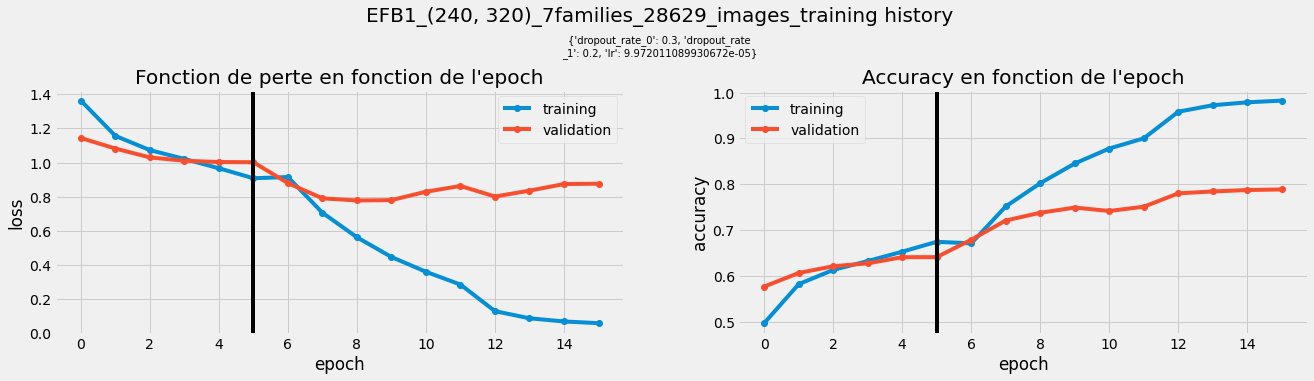

time: 70.4 ms (started: 2022-02-07 15:00:42 +00:00)


In [101]:
training_history = Image.open(export_dir + pathinfos +  '_' + best_model_number +   '_training_history.jpeg')
training_history 

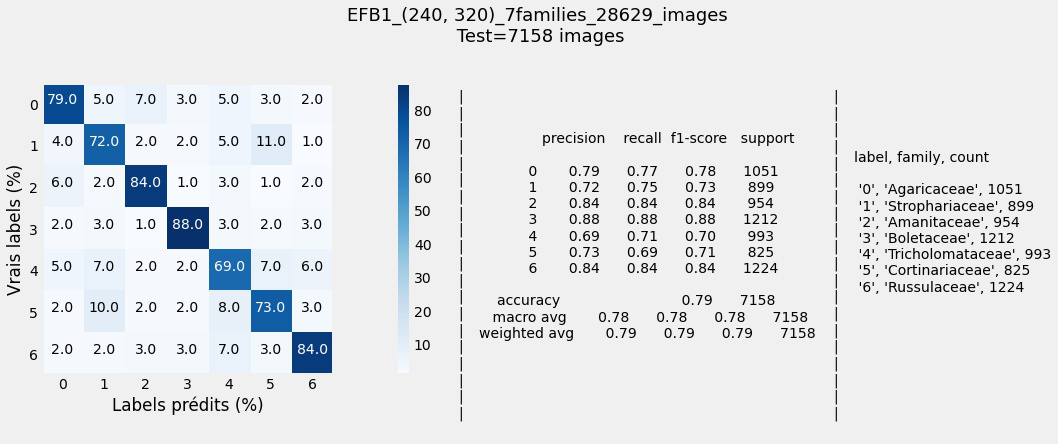

time: 94.7 ms (started: 2022-02-07 15:00:42 +00:00)


In [102]:
test_set_assessment = Image.open(export_dir + pathinfos +  '_' + best_model_number +  '_conf_matrix.jpeg')
test_set_assessment 

In [103]:
top3_df.iloc[0]

accuracy            0.982741
val_accuracy        0.788690
test_accuracy       0.789327
weighted_f1         0.789362
time_to_fit     -7884.572683
Name: model_#0, dtype: float64

time: 4.89 ms (started: 2022-02-07 15:00:42 +00:00)


In [107]:
print('train/val/test acc = {}/{}/{} - f1 = {} in folder {} in {} min'.format(round(top3_df.iloc[0]['accuracy'],2),
                                                                          round(top3_df.iloc[0]['val_accuracy'],2),
                                                                          round(top3_df.iloc[0]['test_accuracy'],2),
                                                                          round(top3_df.iloc[0]['weighted_f1'],2),
                                                                          export_dir,
                                                                          -round(top3_df.iloc[0]['time_to_fit']//60,0)  

    
                                                                              ))

train/val/test acc = 0.98/0.79/0.79 - f1 = 0.79 in folder /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220207_09H59/ in 132.0 min
time: 21.3 ms (started: 2022-02-07 15:01:44 +00:00)


# Experiments
## Approche transfer learning with unfreeze at start 
  * train/val/test acc = 0.98/0.76/0.76 - f1 = 0.76 in folder 220207_06H35/ in time to fit

  * sur 5 familles pour comparaison anciens élèves (0.77 cf  https://github.com/thibaultkaczmarek/MushPy/blob/main/models/iteration_2/20210622_model_effnet-datagenerator_unfreeze_GPU_colab_initial.ipynb):
    * train/val acc=1.0/0.82 in 11 epochs in 190.7 minutes with model EFB1 in folder 220204_19H07

## Approche transfer learning freeze + fine tuning en 2 steps:
  * train/val/test = 0.8112/0.7026/0.71 in folder 220206_08H14_ transfer learning freeze + fine tuning
  * idem mais en fixant 2nd step lr à 1e-5 plutot que de continuer sur celui d'avant:
    * train/val/test acc = 0.92/0.72/0.73 - f1 = 0.73 in folder /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220206_12H49/ in time to fit
  * idemavec freeze sur 3 epochs only puis lr 2nd step = lr fin 1step:
    * **acc =  0.78** sur test avec modele 0 mais ça a planté 
  * Nouvel essai avec datagen on + callbacks plus agressifs pour stopper dès début convergence:
    * train/val/test acc = 0.98/0.79/0.79 - f1 = 0.79 in folder 220207_09H59 in 132.0 min
 /!\très long/!\
  * idem sans datagen 

==> a restester avec datagen sur meilleur model avec callback 1 agressif pour stopper dès début convergence puis fine tuning lr le meme que step 1  








In [ ]:
# !kill -9 -1